# 5. XGBoost regression

## 5.1 Imports

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import warnings
import pylab

from ipynb.fs.full.Functions import plotValCurve, plotLearningCurve
from numpy import loadtxt
from pathlib import Path
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from statsmodels.api import qqplot
from xgboost import XGBRegressor

%matplotlib inline
warnings.filterwarnings('ignore')

C:\Users\brtkr\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
PreparedFeatures = pd.read_csv('../Data/PreparedFeatures.csv', sep='\t')
X_train = loadtxt('../Data/X_train.csv', delimiter=',')
y_train = loadtxt('../Data/y_train.csv', delimiter=',')
X_test = loadtxt('../Data/X_test.csv', delimiter=',')
y_test = loadtxt('../Data/y_test.csv', delimiter=',')

In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9550, 39), (9550,), (2388, 39), (2388,))

In [4]:
mse = metrics.make_scorer(metrics.mean_squared_error, greater_is_better=False)

## 5.2 Ploting learning curve, model scalability and performance

In [5]:
xgb = XGBRegressor()

<module 'matplotlib.pyplot' from 'C:\\Users\\brtkr\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

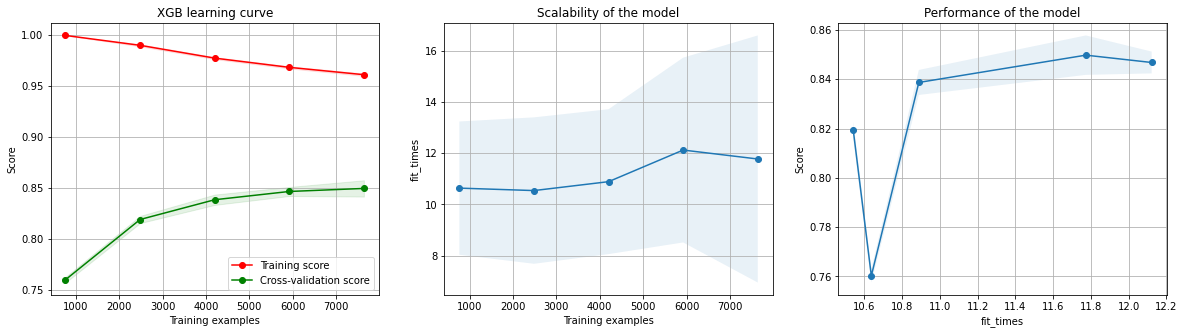

In [6]:
plotLearningCurve(estimator=xgb, title = "XGB learning curve", X=X_train,
                  y=y_train, cv=5, n_jobs=-1)

Like in svr case training curve and cross-validation curve are convergent along the x-axis but gap between curves is larger. Training score is much higher, which may mean that XGBoost tends more to overfit but in cross-validation reaches plateau at score 0.85 R^2 with 7500 training examples. XGB has the best scalability among all three models. Samples collection enlargement does not imply much fit time increase. What is more examples number above 6000 decreases training time.

## 5.3 Hyperparameter tuning 

### 5.3.1 Eta

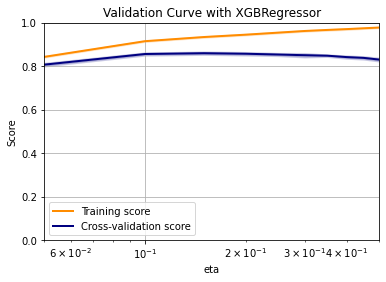

In [7]:
plotValCurve(estimator=xgb, X = X_train, y = y_train, param_name='eta',
             param_range=np.linspace(0.05, 0.5, 10), cv=5)

In [8]:
gridCV = GridSearchCV(xgb, {'eta':[0.06, 0.08, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]},
                      cv=5, n_jobs=-1, scoring=mse)

gridCV.fit(X_train, y_train)

print('Best parameters:' + str(gridCV.best_params_))
print('Best accuracy in cross-validation:' + str(gridCV.best_score_))

Best parameters:{'eta': 0.15}
Best accuracy in cross-validation:-0.03083537526400258


Eta is step size shrinkage used in update to prevents overfitting. For this model Optimal eta value is persumably between 0.1 and 0.2, when value is higher there is visible score fall.

### 5.3.2 Colsample by tree

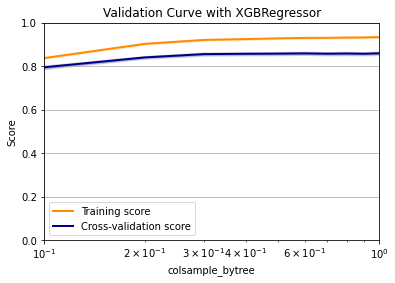

In [9]:
plotValCurve(estimator=XGBRegressor(eta=0.15), X=X_train, y=y_train,
             param_name='colsample_bytree', param_range=np.linspace(0.1, 1, 10), cv=5)

In [10]:
xgb_grid = XGBRegressor(eta=0.15)

gridCV = GridSearchCV(xgb_grid, {'colsample_bytree':np.linspace(0.1, 1., 10)},
                      cv=5, n_jobs=-1, scoring=mse)

gridCV.fit(X_train, y_train)

print('Best parameters:' + str(gridCV.best_params_))
print('Best (lowest) rmse in cross-validation:' + str(gridCV.best_score_))

Best parameters:{'colsample_bytree': 1.0}
Best (lowest) rmse in cross-validation:-0.03083537526400258


Colsamples by tree represents the fraction of columns to be randomly sampled for each tree. It might improve overfitting.

### 5.3.3 Learning rate

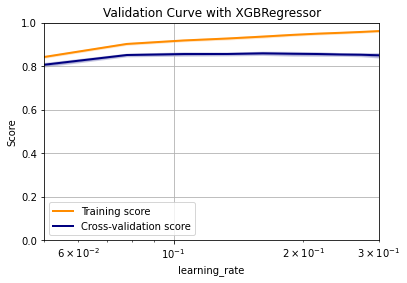

In [11]:
param = {
    'eta':0.15,
    'colsample_bytree':1.0
}

plotValCurve(estimator=XGBRegressor(**param), X=X_train, y=y_train,
             param_name='learning_rate', param_range=np.linspace(0.05, 0.3, 10), cv=5)

In [12]:
xgb_grid = XGBRegressor(**param)

gridCV = GridSearchCV(xgb_grid, {'learning_rate':np.linspace(0.06, 0.24, 10)},
                      cv=5, n_jobs=-1, scoring=mse)

gridCV.fit(X_train, y_train)

print('Best parameters:' + str(gridCV.best_params_))
print('Best (lowest) rmse in cross-validation:' + str(gridCV.best_score_))

Best parameters:{'learning_rate': 0.16}
Best (lowest) rmse in cross-validation:-0.03090657826032365


The learning rate determines size of models parameters adjustment step at each iteration of model training. Too big can cause overpassing optimal parameter value. Grid search cross-validation returns 0.16 learning rate as optimal for this model.

### 5.3.4 Alpha 

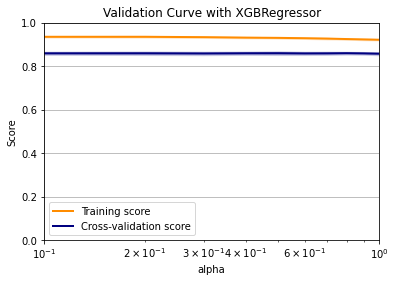

In [13]:
param = {
    'eta':0.15,
    'colsample_bytree':1.0,
    'learning_rate': 0.16
}

plotValCurve(estimator=XGBRegressor(**param), X=X_train, y=y_train,
             param_name='alpha', param_range=np.linspace(0.1, 1, 10), cv=5)

In [14]:
xgb_grid = XGBRegressor(**param)

gridCV = GridSearchCV(xgb_grid, {'alpha':np.linspace(0.1, 1., 10)},
                      cv=5, n_jobs=-1, scoring=mse)

gridCV.fit(X_train, y_train)

print('Best parameters:' + str(gridCV.best_params_))
print('Best (lowest) rmse in cross-validation:' + str(gridCV.best_score_))

Best parameters:{'alpha': 0.8}
Best (lowest) rmse in cross-validation:-0.03080150434986525


L1 regularization term on weights. Increasing makes model more conservative, default value is 0. Grid search suggests using alpha 0.8. 

### 5.3.5 Max depth

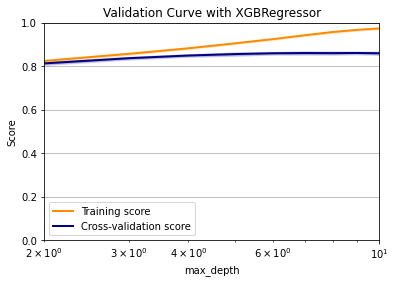

In [15]:
param = {
    'eta':0.15,
    'colsample_bytree':1.0,
    'learning_rate': 0.16,
    'alpha': 0.8
}

plotValCurve(estimator=XGBRegressor(**param), X=X_train, y=y_train,
             param_name='max_depth', param_range=np.array([2,3,4,5,6,7,8,9,10]), cv=5)

In [16]:
xgb_grid = XGBRegressor(**param)

gridCV = GridSearchCV(xgb_grid, {'max_depth':np.array([3,4,5,6,7,8,9,10])},
                      cv=5, n_jobs=-1, scoring=mse)

gridCV.fit(X_train, y_train)

print('Best parameters:' + str(gridCV.best_params_))
print('Best (lowest) rmse in cross-validation:' + str(gridCV.best_score_))

Best parameters:{'max_depth': 9}
Best (lowest) rmse in cross-validation:-0.030508165177416623


Max depth determines maximum depth per tree. A deeper tree usually increases performance but also may cause overfitting. For this model max depth equal 9 is optimal.

### 5.3.6 Subsample

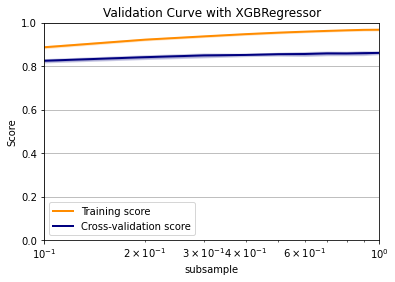

In [17]:
param = {
    'eta':0.15,
    'colsample_bytree':1.0,
    'learning_rate': 0.16,
    'alpha': 0.8,
    'max_depth': 9
}

plotValCurve(estimator=XGBRegressor(**param), X=X_train, y=y_train,
             param_name='subsample', param_range=np.linspace(0.1, 1, 10), cv=5)

In [18]:
xgb_grid = XGBRegressor(**param)

gridCV = GridSearchCV(xgb_grid, {'subsample':np.linspace(0.1, 1., 10)},
                      cv=5, n_jobs=-1, scoring=mse)

gridCV.fit(X_train, y_train)

print('Best parameters:' + str(gridCV.best_params_))
print('Best (lowest) rmse in cross-validation:' + str(gridCV.best_score_))

Best parameters:{'subsample': 1.0}
Best (lowest) rmse in cross-validation:-0.030508165177416623


Subsample determines size of randomly selected samples sets for each tree training. When = 1 there is no random selection, all samples are in use and it is default setting.

### 5.3.7 N-estimators 

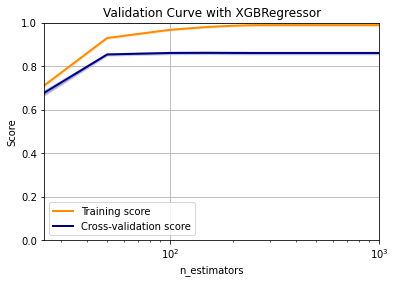

In [19]:
param = {
    'eta':0.15,
    'colsample_bytree':1.0,
    'learning_rate': 0.16,
    'alpha': 0.8,
    'max_depth': 9,
    'subsample': 1.0
}

plotValCurve(estimator=XGBRegressor(**param), X=X_train, y=y_train,
             param_name='n_estimators', param_range=np.array([25,50,100, 150, 200, 250, 300, 500, 1000]), cv=5)

In [20]:
xgb_grid = XGBRegressor(**param)

gridCV = GridSearchCV(xgb_grid, {'n_estimators':np.array([50, 100, 200, 300, 500, 1000])},
                      cv=5, n_jobs=-1, scoring=mse)

gridCV.fit(X_train, y_train)

print('Best parameters:' + str(gridCV.best_params_))
print('Best (lowest) rmse in cross-validation:' + str(gridCV.best_score_))

Best parameters:{'n_estimators': 200}
Best (lowest) rmse in cross-validation:-0.03047972933681032


The number of trees in trained ensemble. Value greater than 0, default equals 100. 

## 5.4 Tuned model evaluation

In [21]:
param = {
    'eta':0.15,
    'colsample_bytree':1.0,
    'learning_rate': 0.16,
    'alpha': 0.8,
    'max_depth': 9,
    'subsample': 1.0,
    'n_estimators': 200
}

xgb = XGBRegressor(**param)

xgb.fit(X_train, y_train)

XGBRegressor(alpha=0.8, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, enable_categorical=False,
             eta=0.15, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.16, max_delta_step=0,
             max_depth=9, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.800000012, reg_lambda=1, scale_pos_weight=1,
             subsample=1.0, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [22]:
y_pred = xgb.predict(X_test)

### 5.4.1 RMSE

In [23]:
metrics.mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False)

0.1657851811590846

### 5.4.2 Adjusted R-squared

In [24]:
adj_r2 = 1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
adj_r2

0.8706088402959504

Metrics are significantly better than basic model performance. Model hyperparameters tuning brought the biggest difference among all three model types, no matter XGBoost did the best in preliminary modelling. 

### 5.4.3 Feature importances

In [25]:
feature_importances = dict(zip(PreparedFeatures.columns.values.tolist(), xgb.feature_importances_))

dict(sorted(feature_importances.items(), key = lambda x: x[1], reverse = True)[:5])

{'Type_u': 0.37198138,
 'RegionName_Southern Metropolitan': 0.28861305,
 'Bedrooms': 0.065143295,
 'LogDistance': 0.030764174,
 'YearBuilt': 0.024863983}

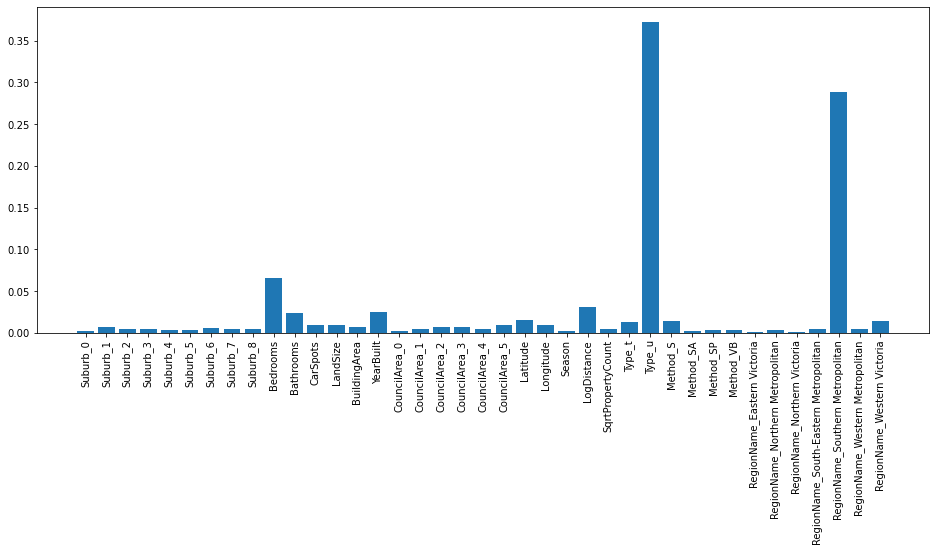

In [26]:
plt.figure(figsize=(16,6))
plt.bar(feature_importances.keys(), feature_importances.values())
plt.xticks(rotation=90)
plt.show()

Unlike random forrest and support vector regressor two variables dominates in importance for the model. Type u reffers flats and semidetached buildings and that may have significant influence on price. The second most important is South-eastern region. Presumably it is the most desirable part of the city. It is only in third place variable describing properties size aspects.

### 5.4.4 Residuals analysis

In [27]:
residuals = y_test - y_pred
residuals

array([ 0.02642381, -0.04965059,  0.15811734, ..., -0.22277153,
       -0.15843142, -0.11953792])

#### 5.4.4.1 Residuals distribution

<AxesSubplot:ylabel='Density'>

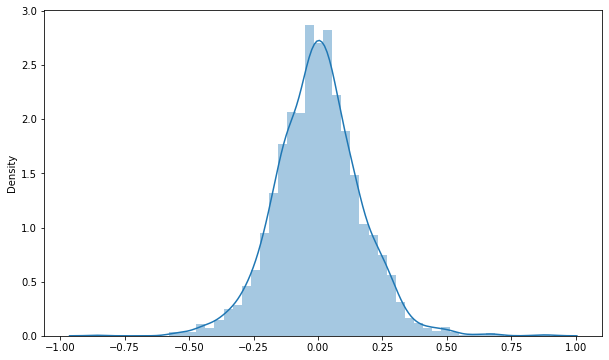

In [28]:
plt.subplots(figsize=(10,6))
sns.distplot(residuals)

Residuals distribution is little more deformed than previous models(rfr, svr). Especially right tail, there is visible thickening around 0.5 and 0.7. 

#### 5.4.4.2 Residuals Q-Q plot

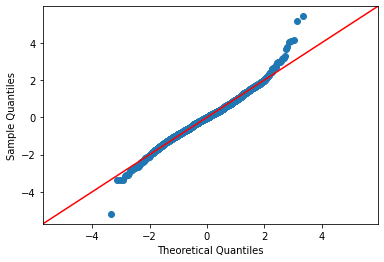

In [29]:
qq = residuals.copy()
m = qq.mean()
st = qq.std()

for i in range(0, len(qq),1):
    qq[i] = (qq[i]-m)/st
    
qqplot(qq, line='45')
pylab.show()

Q-Q normality plot shows that left tail is almost perfectly distributed, right tail has larger deviations, it is cause by previously mentioned predictions with quite big error around 0.5-0.7. But such deviations does not imply model incorrectness.

#### 5.4.4.3 Heteroskedascity plot

<AxesSubplot:>

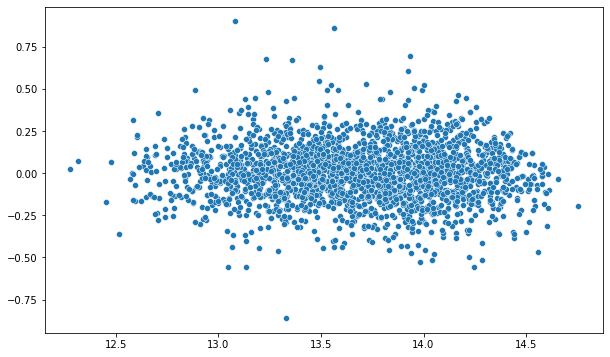

In [30]:
plt.subplots(figsize=(10,6))
sns.scatterplot(x = y_pred, y = residuals)

Random dispersion indicates that variances of error terms are constant, and error is homoskedastic.

#### 5.4.4.4 Scale location plot

Text(0.5, 0, 'Fitted value')

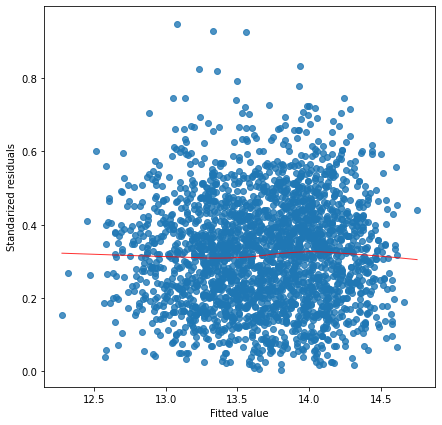

In [31]:
model_norm_residuals_abs_sqrt=np.sqrt(np.abs(residuals))

plt.figure(figsize=(7,7))
sns.regplot(y_pred.reshape(-1), model_norm_residuals_abs_sqrt,
              scatter=True,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.ylabel("Standarized residuals")
plt.xlabel("Fitted value")

Residuals are spread equally along ranges of predictors. Graph also indicated that heteroskedasticity does not appears. Residuals analysis does not indicate that the assumptions of the model are not met.

In [32]:
xgb_saved_model = pickle.dump(xgb, open(r'..\Models\xgb_best_model.pkl','wb'))